# **Google Play Store - Analisando os Aplicativo Mais Populares**

Os dados de aplicativos de Play Store têm um potencial enorme para levar os negócios de criação de aplicativos ao sucesso. Insights podem ser obtidos para que os desenvolvedores trabalhem e capturem o mercado Android.

Nesse projeto exploramos os dados dos aplicativos existentes no loja virtual *Goggle Play Store*. Vamos analisar as categorias, gêneros, tamanhos, preços e os apps mais instalados.

## Objetivo do projeto

Analisar quais são os tipos de apps mais usados/instalados, fornecendo assim informações sobre possiveis investimentos na criação, compra e venda de novos apps.

## 1. Importando os dados

Os dados usados neste projeto foram retiradps do Kaggle, que é uma das maiores comunidades de data science do mundo.

link do dataset: <a href="https://www.kaggle.com/lava18/google-play-store-apps" target="_blanck"> Google Play Store Apps </a>.

In [1]:
# Importando as bibliotecas

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import cm 
import seaborn as sns

In [2]:
# Importando o dataset
googleplay = pd.read_csv("googleplaystore.csv")
googleplay.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [3]:
print("O dataset possui: ")
print("Linhas: ", googleplay.shape[0])
print("Colunas: ", googleplay.shape[1])

O dataset possui: 
Linhas:  10841
Colunas:  13


## 2. Limpando os dados

Antes de iniciar qualquer análise, precisamos limpar e organizar os dados.

In [4]:
# Verifica os formatos (tipos de dados) nas colunas do dataset
googleplay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


Temos muitas colunas do tipo 'object', as quais muitas delas precisam ser convertidas para o formato numérico.

Antes disso, vamos facilitar o trabalho excluindo colunas que não serão utilizadas e arrumando dados faltantes.

In [5]:
# Remove as colunas não usadas, relacionadas a versões e update
googleplay = googleplay.drop(columns=["Last Updated", "Android Ver", "Current Ver"], axis=1)

# Mostra a quantidade de dados faltantes em cada coluna
googleplay.isnull().sum().sort_values(ascending=False)


Rating            1474
Content Rating       1
Type                 1
Genres               0
Price                0
Installs             0
Size                 0
Reviews              0
Category             0
App                  0
dtype: int64

A coluna Rating possui 1474 linhas com dados nulos, o que é pouco se considerarmos que o dataset possui 10841. Portanto podemos apagar essas linhas.

In [6]:
# Apaga as linhas com dados faltantes (NaN)
googleplay = googleplay.dropna(axis=0)

In [7]:
# Remove dados duplicados, caso houver

googleplay = googleplay[googleplay.duplicated("App")].drop_duplicates(keep=False)


In [8]:
# Altera a coluna "Reviews" para numérica 
googleplay["Reviews"] = googleplay["Reviews"].astype(np.int64)

In [9]:
# Converte os valores "Varies with device" para NaN na coluna 'Size'
googleplay["Size"].replace("Varies with device", np.nan, inplace =True)

# Remove "M"and "k" da coluna 'Size'
googleplay["Size"] = googleplay["Size"].str.replace('k', "000").str.replace('M', "000000").astype(np.float64)

# Troca os valores NaN pelo valor médio da coluna 'Size' 
googleplay["Size"].fillna(googleplay.groupby("Category")["Size"].transform("mean"), inplace=True)

In [10]:
#Remove "+" e "," da coluna 'Installs' e converte para numérico
googleplay["Installs"] = googleplay["Installs"].str.rstrip("+").apply(lambda x: x.replace(",","")).astype(np.int64)


In [11]:
#Remove "$" da coluna 'Price'
googleplay["Price"] = googleplay.Price.apply(lambda x: x.strip("$"))

# Converte a coluna para numérico
googleplay["Price"] = pd.to_numeric(googleplay.Price)

Agora que as colunas estão com seus dados limpos, podemos separar os apps por gêneros.

In [12]:
# Cria listas 
googleplay["First_Genre"] = np.nan
googleplay["Second_Genre"] = np.nan

# Loop para os elementos da coluna 'Genres'
for genre in googleplay["Genres"].values:
    index = googleplay[googleplay['Genres'] ==genre].index # seleciona o índice da linha
    g0 = str(genre).split(";")[0]      # dividi os elementos da linha pela ";" e pega o primeiro elemnto
    googleplay.loc[index,"First_Genre"] = str(g0) # adiciona na lista
    g1 = str(genre).split(";")[-1]     # pega o segundo elemento
    googleplay.loc[index,"Second_Genre"] = str(g1) # adiciona na lista

# Apaga a coluna 'Genre'
googleplay.drop("Genres", axis=1, inplace=True) 

In [13]:
googleplay.head(10)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,First_Genre,Second_Genre
229,Quick PDF Scanner + OCR FREE,BUSINESS,4.2,80805,21136364.9,5000000,Free,0.0,Everyone,Business,Business
256,ZOOM Cloud Meetings,BUSINESS,4.4,31614,37000000.0,10000000,Free,0.0,Everyone,Business,Business
266,Zenefits,BUSINESS,4.2,296,14000000.0,50000,Free,0.0,Everyone,Business,Business
267,Google Ads,BUSINESS,4.3,29313,20000000.0,5000000,Free,0.0,Everyone,Business,Business
269,Slack,BUSINESS,4.4,51507,21136364.9,5000000,Free,0.0,Everyone,Business,Business
270,FreshBooks Classic,BUSINESS,4.1,1802,26000000.0,100000,Free,0.0,Everyone,Business,Business
271,Insightly CRM,BUSINESS,3.8,1383,51000000.0,100000,Free,0.0,Everyone,Business,Business
273,HipChat - Chat Built for Teams,BUSINESS,3.8,5868,20000000.0,500000,Free,0.0,Everyone,Business,Business
274,Xero Accounting Software,BUSINESS,3.5,2111,21136364.9,100000,Free,0.0,Everyone,Business,Business
275,"MailChimp - Email, Marketing Automation",BUSINESS,4.1,5448,12000000.0,500000,Free,0.0,Everyone,Business,Business


## 3. Análise Exploratória de Dados

Iniciaremos a análise dos dados de modo a resumir suas características principais e extrair informações relevantes.


### 3.1 Categorias dos Apps

Nossa primeira análise é para responder a questão: quais são as categorias que apresentam maior quantidade de app no *Goggle Play Store*? 

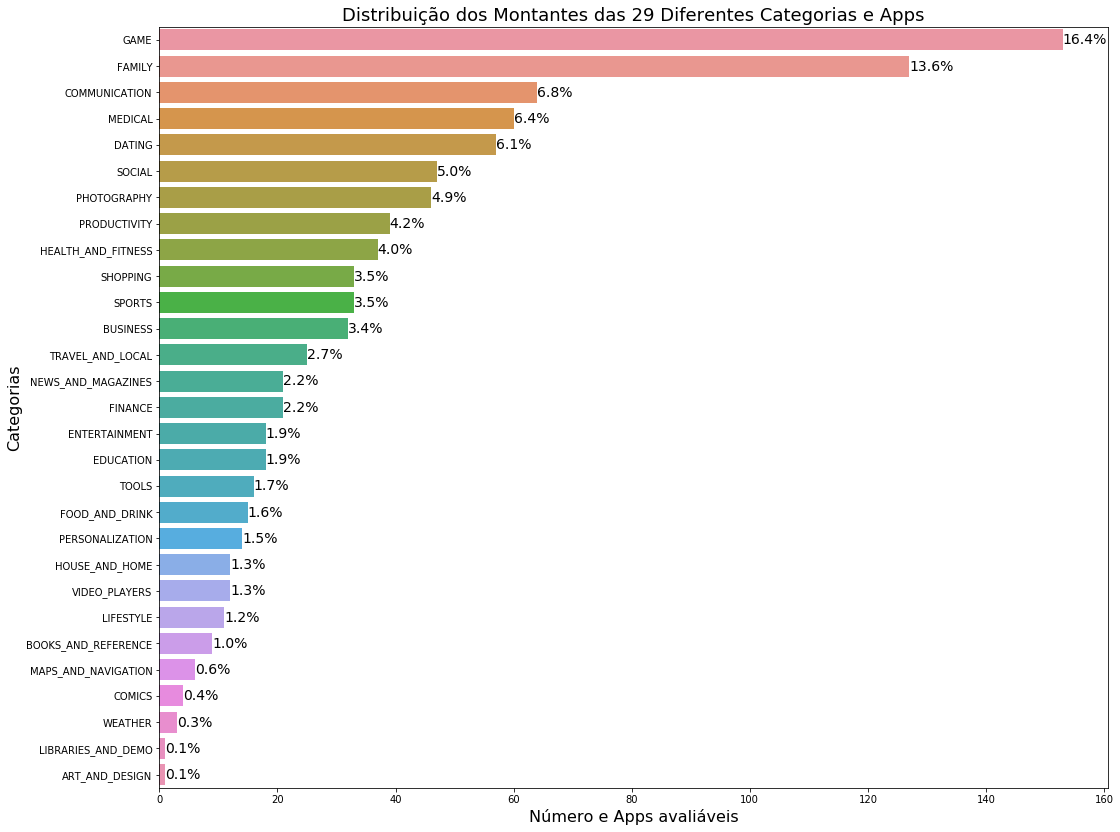

In [16]:
# Contabiliza e ordena os valores da coluna 'Category'
category = googleplay["Category"].value_counts().sort_values(ascending=False)

# Desenha um gráfico de barras
plt.figure(figsize=(17,14))
fig_categ_bar = sns.barplot(y = category.index, x = category.values)
plt.ylabel(ylabel='Categorias', fontsize = 16)
plt.xlabel(xlabel='Número e Apps avaliáveis', fontsize = 16)
plt.title("Distribuição dos Montantes das {} Diferentes Categorias e Apps".format(len(category)), fontsize = 18)

def percentages(plot, column):
    
    ''' Escreve as porcentagens no gráfico'''

    total = sum(column)
    for p in plot.patches:
        
        percentage = '{:1.1f}%'.format((p.get_width()/total)*100) # calcula a porcentagem 
        x = p.get_x() + p.get_width() # define a posição x no gráfico
        y = p.get_y() + p.get_height()/2  # defina a posição y no gráfico
        plot.annotate(percentage, (x, y), size = 14, verticalalignment='center') # escreve no gáfico
    
percentages(fig_categ_bar, category.values)

No gráfico acima vemos que a maior quantidade de apps existentes na play store são sobre **games** e **family**, somando 20% do total. 

Os apps sobre **communication**, **medical** e **dates** estão logo em seguida, somando juntos 19,3% do total de apps. 

As cinco primeiras categorias contabilizam juntas 39,3% de todos os apps na loja virtal. 

### 3.2 Gêneros de Apps

Vamos ver quais os gêneros que classificam os apps mais dominantes na play store.

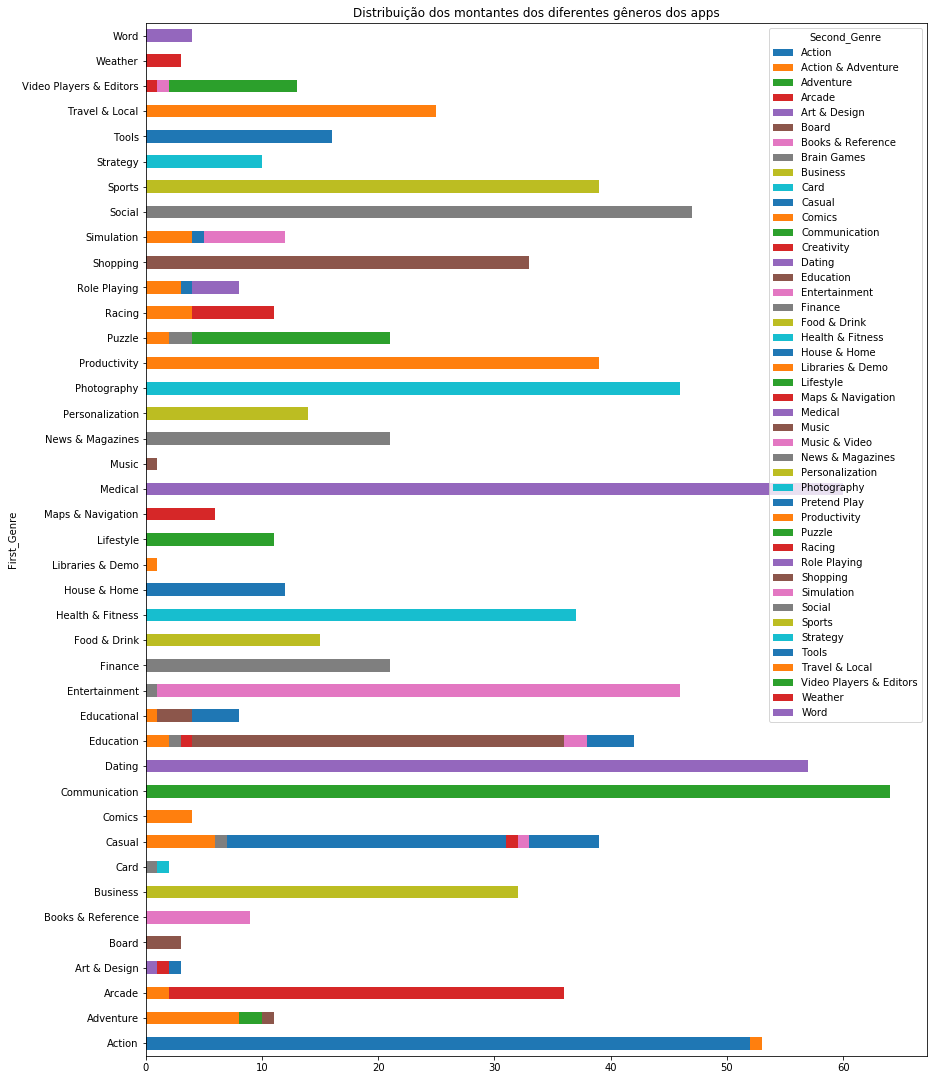

In [33]:
# Cria uma tabela com os dois tipos de gêneros usados
table_genre = pd.crosstab(index=googleplay["First_Genre"], columns=googleplay["Second_Genre"])

# Desenha um gráfico de barras com as quantidades
table_genre.plot(kind='barh', stacked=True, figsize=(14,19),
        title="Distribuição dos montantes dos diferentes gêneros dos apps")
plt.show()

Com esse gráfico é possível visualizar as proporções de cada um dos segundos gêneros em relação com os primeiros gêneros usados pra classificar os apps.



### 3.3 Número de apps instalados por categoria e gênero

Outra questão importante a ser respondida é: quais são as categorias e gêneros mais populares entre os usuários? Quando dizemos "mais populares" estamos nos referindo a quantidade de apps instalados.


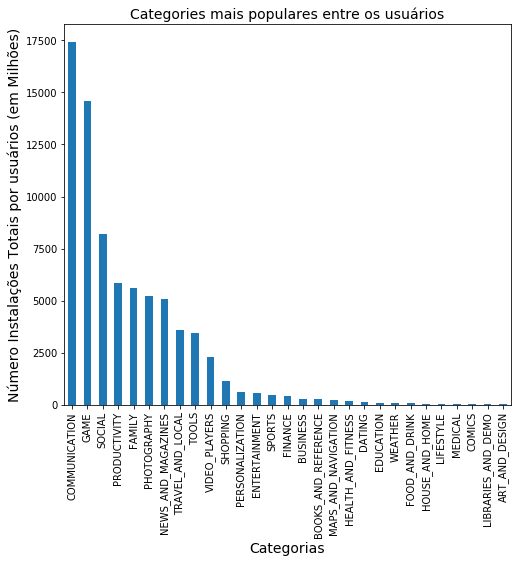

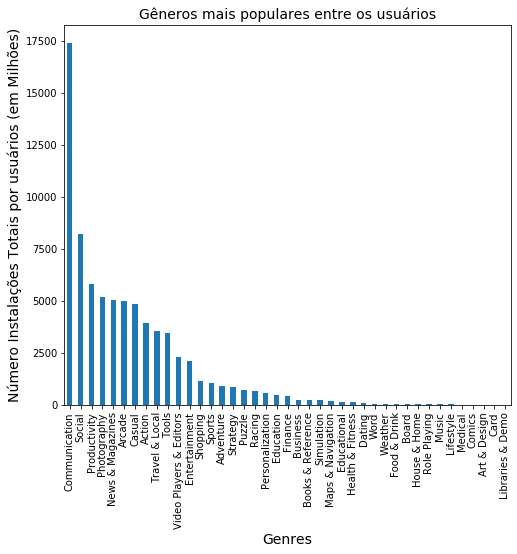

In [34]:
# Agrupa o número de instalações por categoria
installs_category = googleplay.groupby("Category")["Installs"].sum().sort_values(ascending = False)
per_million = round(installs_category/(1000000)).astype(int) 

# Agrupa o número de instalações pelo primeiro gênero de classificação
installs_genre1 = googleplay.groupby("First_Genre")["Installs"].sum().sort_values(ascending = False)
per_million_genre = round(installs_genre1/(1000000)).astype(int)

# Desenha  um gráfico de barras com as quantidades
plt.figure(figsize=(8,7))
per_million.plot(kind='bar', x=per_million.index, y=per_million.values)
plt.title("Categories mais populares entre os usuários", fontsize = 14)
plt.xlabel(xlabel='Categorias', fontsize = 14)
plt.ylabel(ylabel='Número Instalações Totais por usuários (em Milhões)', fontsize = 14)

plt.figure(figsize=(8,7))
per_million_genre.plot(kind='bar', x=per_million_genre.index, y=per_million_genre.values)
plt.title("Gêneros mais populares entre os usuários", fontsize = 14)
plt.xlabel(xlabel='Genres', fontsize = 14)
plt.ylabel(ylabel='Número Instalações Totais por usuários (em Milhões)', fontsize = 14)
plt.show()

Dos gráficos acimas vemos que as cinco categorias mais populares são: **Communication, games, social, productivity e family**.

Já os cinco gêneros de apps mais populares são: **Communication, social, productivity, photography e news & magazines**

### 3.4 Top 10 apps mais instalados na categoria games e no gênero communication

Podemos estar interessados em saber quais são os dez nomes de apps mais populares na categoria **game** e no gênero **comunicação**.

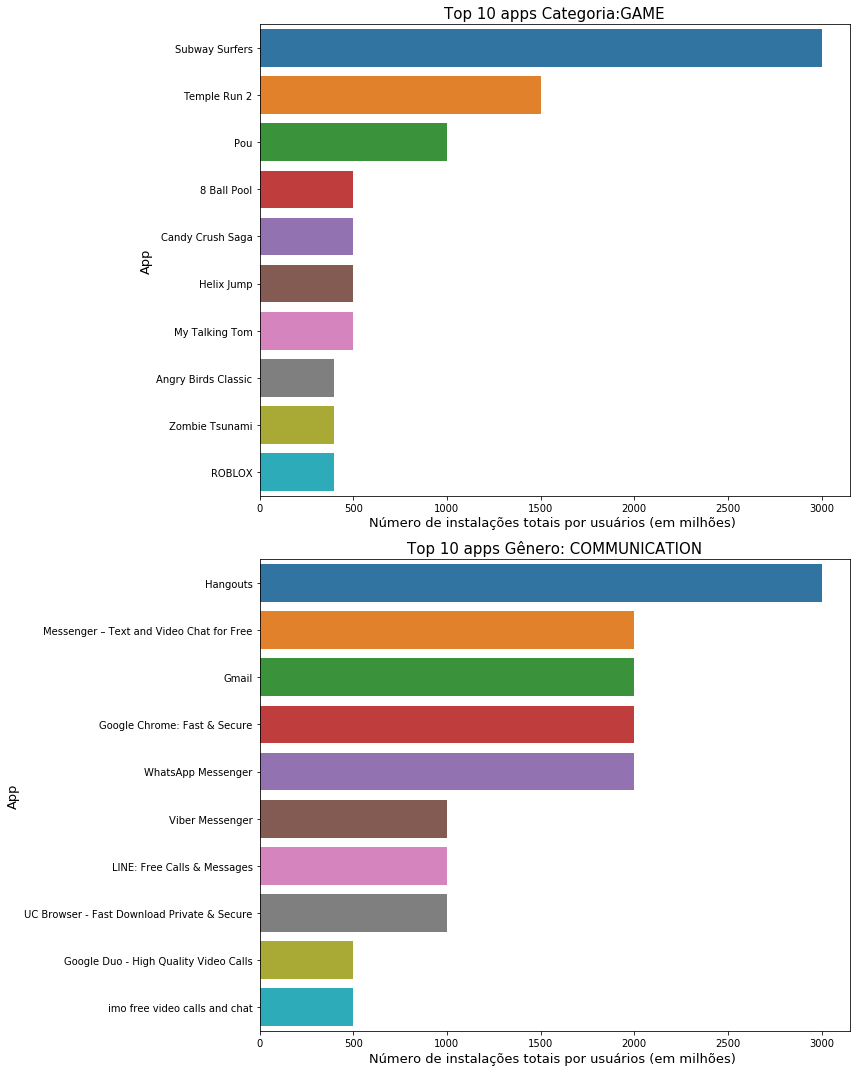

In [36]:
# Localiza os app por categoria=game e ordena por quantidade de intalações
game = googleplay.loc[googleplay["Category"] == 'GAME'].groupby("App")["Installs"].sum().sort_values(ascending = False)
game_per_million = game.div(1000000).round().astype(int)

# Localiza os app por genero=communication e ordena por quantidade de intalações
communication = googleplay.loc[(googleplay["First_Genre"] == 'Communication')].groupby("App")["Installs"].sum().sort_values(ascending = False)
communication_per_million = communication.div(1000000).round().astype(int)


figg, ax = plt.subplots(2,1, figsize=(12,15))
ax[0].set_title('Top 10 apps Categoria:GAME',fontsize=15)
ax[1].set_title('Top 10 apps Gênero: COMMUNICATION',fontsize=15)
ax[0].set_xlabel('Número de instalações totais por usuários (em milhões) ', fontsize=13)
ax[0].set_ylabel('Apps', fontsize=13)
ax[1].set_xlabel('Número de instalações totais por usuários (em milhões) ', fontsize=13)
ax[1].set_ylabel('Apps', fontsize=13)

plot_game = game_per_million[:10]
sns.barplot(ax=ax[0],y=plot_game.index, x=plot_game.values)

plot_communication = communication_per_million[:10,]
sns.barplot(ax=ax[1], y=plot_communication.index, x=plot_communication.values)

plt.tight_layout()
plt.show()


### 3.5 Distribuição de aplicativos gratuitos e pagos de acordo com suas avaliações 

Será que os apps pagos são melhores avaliados que os gratuitos? Para responder essa questão podemos fazer um gráfico da distribuição das avaliações e calcular seus valores médios.

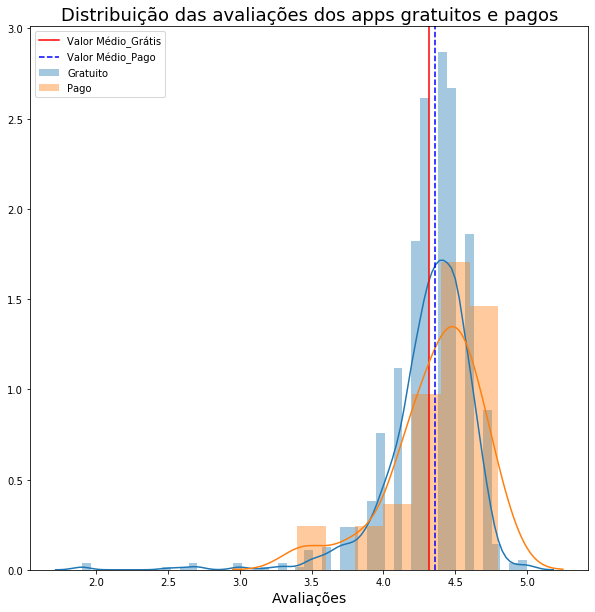

In [38]:
# Localiza os apps gratuitos
free_app = googleplay[googleplay["Type"] == 'Free']
# Calcula o valor médio
mean = round(free_app['Rating'].mean(), 3)

# Localiza os apps pagos
paid_app = googleplay[googleplay["Type"] == 'Paid']
# Calcula o valor médio
meanp = round(paid_app['Rating'].mean(), 2)

fig = plt.figure(figsize=(10,10))

# Desenha os gráficos de distribuição
free_plot = sns.distplot(free_app["Rating"], label='Gratuito')
free_plot.axvline(mean, color='r', linestyle='-', label="Valor Médio_Grátis")

paid_plot = sns.distplot(paid_app["Rating"], label='Pago')
paid_plot.axvline(meanp, color='b', linestyle='--', label="Valor Médio_Pago")

plt.legend()
plt.xlabel("Avaliações", fontsize = 14)
plt.title('Distribuição das avaliações dos apps gratuitos e pagos', fontsize = 18)
plt.show()


Do gráfico acima vemos que os apps gratuitos recebem uma quantidade maior de avaliações que os pagos. 

Os valores médios das avaliações para os dois tipos de apps são próximos, sendo que os **app gratuitos são ligeiramente melhores avaliados**.

### 3.6 Tamanho vs Avaliações para apps gratuitos e pagos

Usando como coferência o fato dos apps gratuitos receberem mais quantidade de avaliações, podemos tentar responder a outra questão: o tamanho dos apps influência na sua avalição?

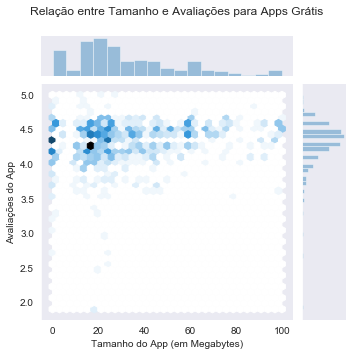

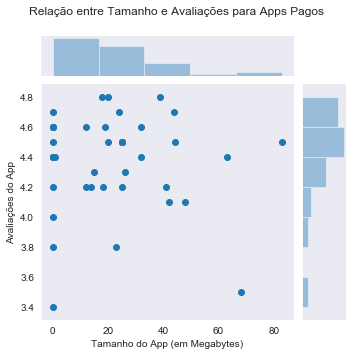

In [40]:
sns.set_style("dark")
#Apps gratuitos
join_free = sns.jointplot(x = free_app["Size"].div(1000000), y = free_app["Rating"], kind='hex', height=5)
join_free.fig.suptitle("Relação entre Tamanho e Avaliações para Apps Grátis")
join_free.set_axis_labels('Tamanho do App (em Megabytes)', 'Avaliações do App')
plt.subplots_adjust(top=0.9)

# Apps pagos
join_paid = sns.jointplot(x = paid_app["Size"].div(1000000), y = paid_app["Rating"], height=5)
join_paid.fig.suptitle("Relação entre Tamanho e Avaliações para Apps Pagos")
join_paid.set_axis_labels('Tamanho do App (em Megabytes)', 'Avaliações do App')
plt.subplots_adjust(top=0.9)
plt.show()

Os gráficos bivariados com distribuições marginais univariadas acima permitem visualizar onde existe um conccentração de densidades entre os valores das variáveis Tamanho e Avaliações. 

Tanto para os apps grtuitos quanto que para os pagos, vemos que existe **uma concentração maior de avaliações para apps de tamanho em torno de 20 Megabytes**.

### 3.7 Inter-relação entre as variáveis

A última análise que iremos fazer é ver se existe um relação linear entre pares de variáveis em nosso dateset. 

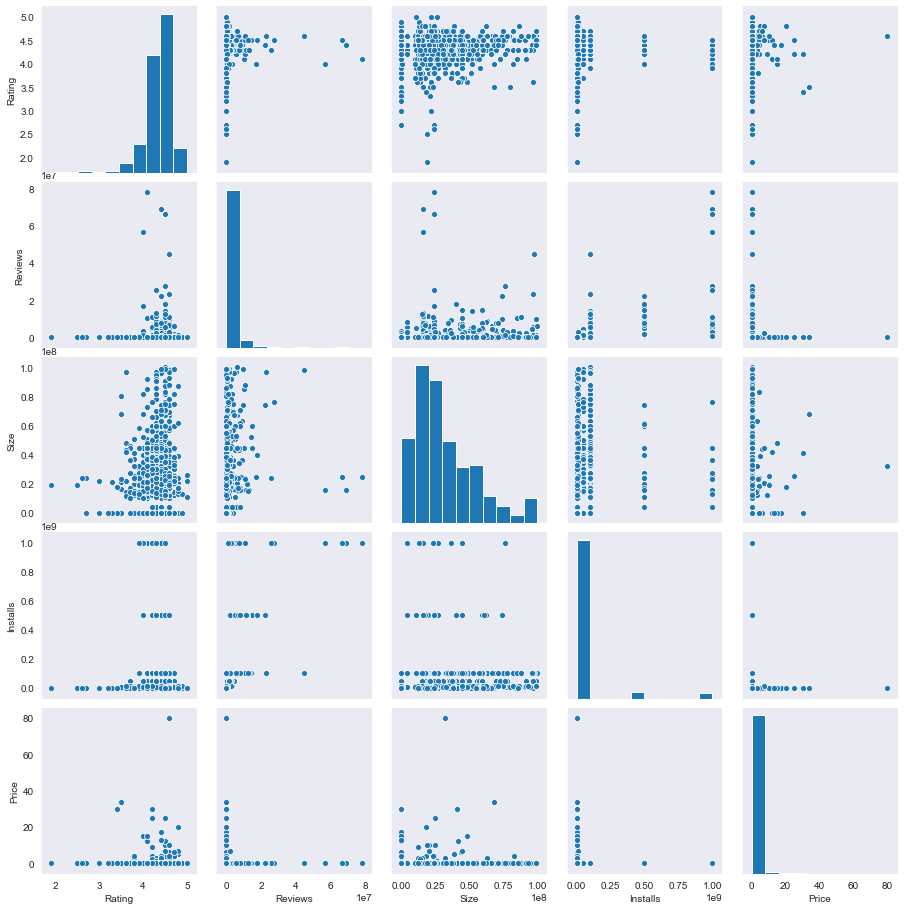

In [35]:
# Desenha gráficos das relações de pares entre as colunas do dataset
sns.pairplot(googleplay)

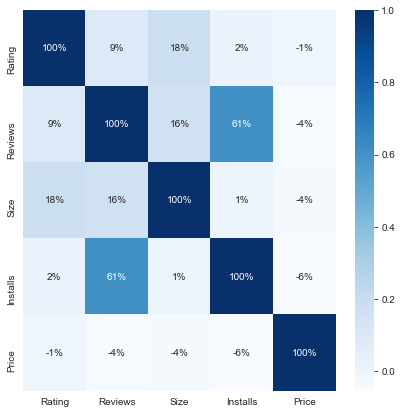

In [36]:
# Correlação entre as colunas
plt.figure(figsize=(7,7))
sns.heatmap(googleplay.corr(), cmap="Blues" ,annot=True,fmt=".0%")
plt.show()

Existe uma  boa relação positiva entre a quantidade de apps instalados ('Installs') e as quantidades de resenhas ('Reviews'). 

Vamos então desenhar um gráfico linear entre essas variáveis.

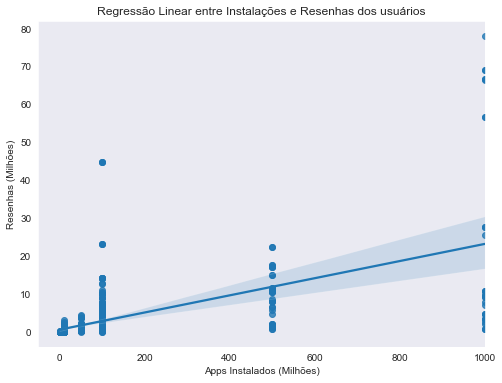

In [41]:
fig = plt.figure(figsize=(8,6))
fig = sns.regplot(x=googleplay["Installs"].div(1000000), y=googleplay["Reviews"].div(1000000))
fig.set_title("Regressão Linear entre Instalações e Resenhas dos usuários")
fig.set_xlabel("Apps Instalados (Milhões)")
fig.set_ylabel("Resenhas (Milhões)")
plt.show()

Existe um padrão linear positivo comportamento entre o número de instalações e a quantidade de resenhas. Ou seja, os menores(maiores) valores da variável Apps Instalados correspondem aos menores(maiores) da variável Resenhas. Isso quer dizer que os apps são mais avaliados quando instalados.

## 4. Conclusões do projeto

O estudo dos aplicativos mais populares da loja virtual *Google Play Store* forneceu informações para que podem ser estabelecidas numa lista de itens.

Alguns dicas para ter um aplicativo de sucesso são:

* **Apps de Jogos, comunicação (troca de mensagens) e relacionados a família são os mais procurados.**

* **Apps gratuitos são mais instalados.**

* **Apps com tamanho por volta de 20 Megabytes são mais instalados.**
